In [ ]:
import torch
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
%matplotlib inline

We assume all data generation/training is complete. If not done yet, please run on the terminal:
```
lasdi burgers1d.yml
```

In [3]:
from lasdi.latent_space import Autoencoder, initial_condition_latent
from lasdi.sindy import simulate_interpolated_sindy
from lasdi.interp import eval_gp
from lasdi.postprocess import simulate_interpolated_sindy_mean, compute_errors

date = '06_17_2024_15_21'
bglasdi_results = np.load('results/bglasdi_' + date + '.npy', allow_pickle = True).item()

Initialize physics solver, according to the config file `burgers1d.yml`

In [4]:
import yaml
from lasdi.workflow import initialize_physics, initialize_latent_space

cfg_file = 'burgers1d.yml'
with open(cfg_file, 'r') as f:
    config = yaml.safe_load(f)

physics = initialize_physics(config)
autoencoder = initialize_latent_space(physics, config)

In [5]:
autoencoder_param = bglasdi_results['autoencoder_param']

X_train = bglasdi_results['final_X_train']
param_train = bglasdi_results['final_param_train']
param_grid = bglasdi_results['param_grid']

sindy_coef = bglasdi_results['sindy_coef']
gp_dictionnary = bglasdi_results['gp_dictionnary']

n_init = bglasdi_results['n_init']
n_samples = 20
n_a_grid = 21
n_w_grid = 21
a_min, a_max = 0.7, 0.9
w_min, w_max = 0.9, 1.1
a_grid = np.linspace(a_min, a_max, n_a_grid)
w_grid = np.linspace(w_min, w_max, n_w_grid)
a_grid, w_grid = np.meshgrid(a_grid, w_grid)

t_grid = bglasdi_results['physics']['t_grid']
x_grid = bglasdi_results['physics']['x_grid']
t_mesh, x_mesh = np.meshgrid(t_grid, x_grid)
Dt = bglasdi_results['physics']['dt']
Dx = bglasdi_results['physics']['dx']

total_time = bglasdi_results['total_time']
start_train_phase = bglasdi_results['start_train_phase']
start_fom_phase = bglasdi_results['start_fom_phase']
end_train_phase = bglasdi_results['end_train_phase']
end_fom_phase = bglasdi_results['end_fom_phase']

data_test = np.load('data/data_test.npy', allow_pickle = True).item()
X_test = data_test['X_test']

time_dim, space_dim = t_grid.shape[0], x_grid.shape[0]

n_hidden = len(autoencoder_param.keys()) // 4 - 1
hidden_units = [autoencoder_param['fc' + str(i + 1) + '_e.weight'].shape[0] for i in range(n_hidden)]
n_z = autoencoder_param['fc' + str(n_hidden + 1) + '_e.weight'].shape[0]

autoencoder.load_state_dict(autoencoder_param)

# Z = autoencoder.encoder(X_train).detach().numpy()
Z = autoencoder.encoder(X_train)
Z0 = initial_condition_latent(param_grid, physics, autoencoder)
Zis_samples, gp_dictionnary, interpolation_data, sindy_coef, n_coef, coef_samples = simulate_interpolated_sindy(param_grid, Z0, t_grid, n_samples, Dt, Z, param_train)
Zis_mean, _, _, _, _, _ = simulate_interpolated_sindy_mean(param_grid, Z0, t_grid, Dt, Z, param_train)

_, _, max_e_relative_mean, _ = compute_errors(n_a_grid, n_w_grid, Zis_mean, autoencoder, X_test, Dt, Dx)
_, _, _, max_std = compute_errors(n_a_grid, n_w_grid, Zis_samples, autoencoder, X_test, Dt, Dx)

gp_pred = eval_gp(gp_dictionnary, param_grid, n_coef)

/Users/chung28/.venv_gpu/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/chung28/.venv_gpu/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/chung28/.venv_gpu/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/chu

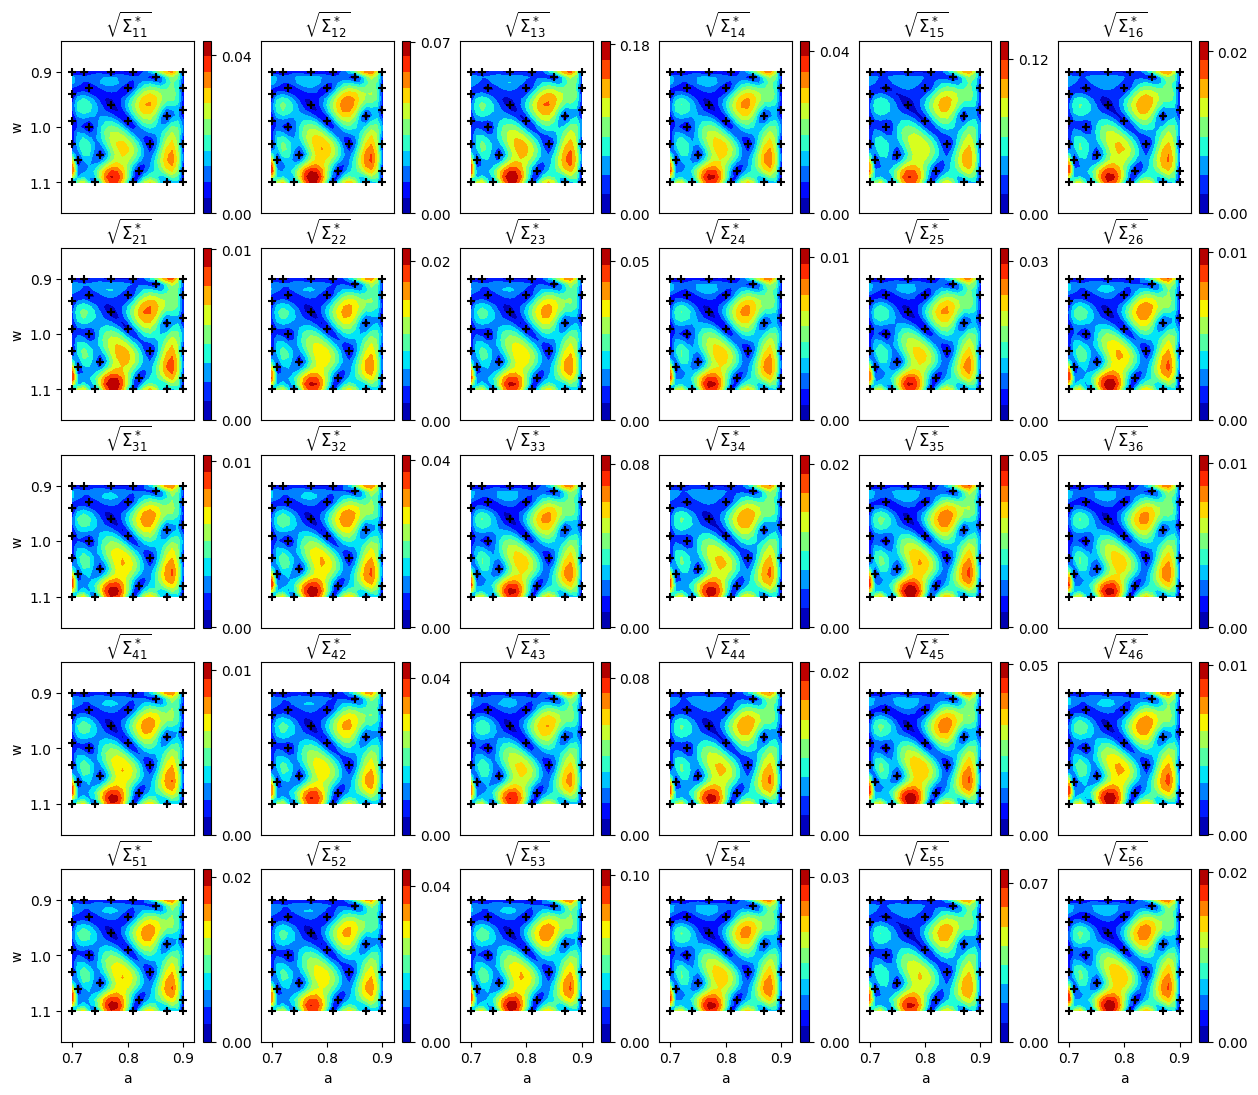

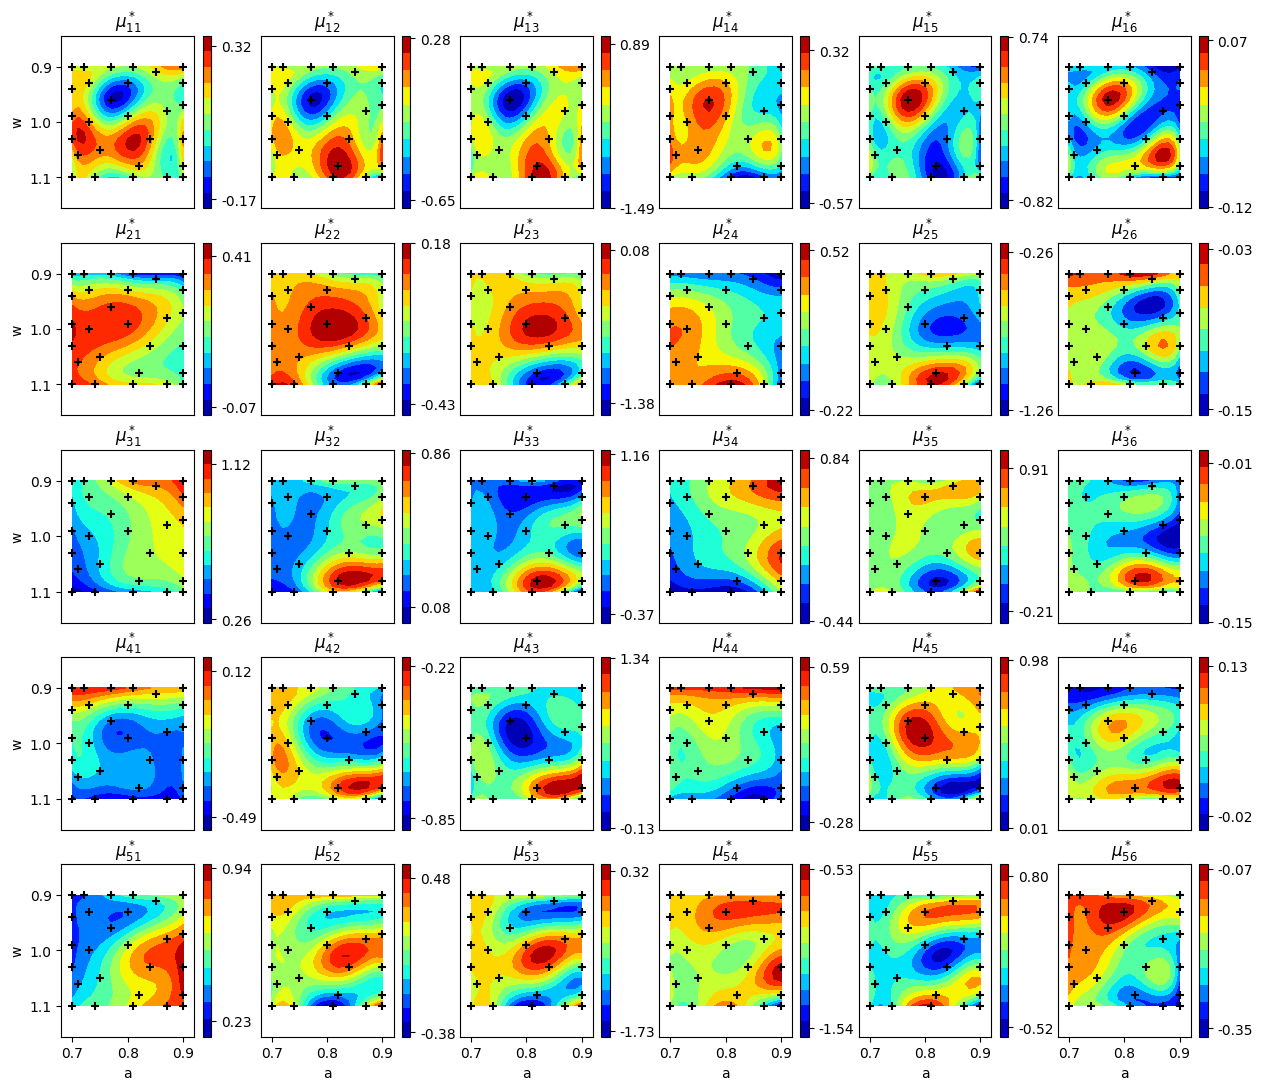

In [6]:
fig1, axs1 = plt.subplots(5, 6, figsize = (15, 13))
fig2, axs2 = plt.subplots(5, 6, figsize = (15, 13))
refine = 10
cm = plt.cm.jet

for i in range(5):
    for j in range(6):
        if j != 5:
            coef_nbr = 6 + j * 5 + i
        else:
            coef_nbr = i + 1
        coef_nbr = 'coef_' + str(coef_nbr)

        std = gp_pred[coef_nbr]['std'].reshape(n_a_grid, n_w_grid)
        p = axs1[i, j].contourf(a_grid, w_grid, std, refine, cmap = cm)
        fig1.colorbar(p, ticks = np.array([std.min(), std.max()]), format='%2.2f', ax = axs1[i, j])
        axs1[i, j].scatter(param_train[:, 0], param_train[:, 1], c='k', marker='+')
        axs1[i, j].set_title(r'$\sqrt{\Sigma^*_{' + str(i + 1) + str(j + 1) + '}}$')
        axs1[i, j].axis('equal')
        axs1[i, j].set_xlim([0.68, 0.92])
        axs1[i, j].set_ylim([0.88, 1.12])
        axs1[i, j].invert_yaxis()
        axs1[i, j].get_xaxis().set_visible(False)
        axs1[i, j].get_yaxis().set_visible(False)

        mean = gp_pred[coef_nbr]['mean'].reshape(n_a_grid, n_w_grid)
        p = axs2[i, j].contourf(a_grid, w_grid, mean, refine, cmap = cm)
        fig2.colorbar(p, ticks = np.array([mean.min(), mean.max()]), format='%2.2f', ax = axs2[i, j])
        axs2[i, j].scatter(param_train[:, 0], param_train[:, 1], c='k', marker='+')
        axs2[i, j].set_title(r'$\mu^*_{' + str(i + 1) + str(j + 1) + '}$')
        axs2[i, j].axis('equal')
        axs2[i, j].set_xlim([0.68, 0.92])
        axs2[i, j].set_ylim([0.88, 1.12])
        axs2[i, j].invert_yaxis()
        axs2[i, j].get_xaxis().set_visible(False)
        axs2[i, j].get_yaxis().set_visible(False)

        if j == 0:
            axs1[i, j].set_ylabel('w')
            axs1[i, j].get_yaxis().set_visible(True)
            axs2[i, j].set_ylabel('w')
            axs2[i, j].get_yaxis().set_visible(True)
        if i == 4:
            axs1[i, j].set_xlabel('a')
            axs1[i, j].get_xaxis().set_visible(True)
            axs2[i, j].set_xlabel('a')
            axs2[i, j].get_xaxis().set_visible(True)

Text(0.5, 1.0, 'GPLaSDI')

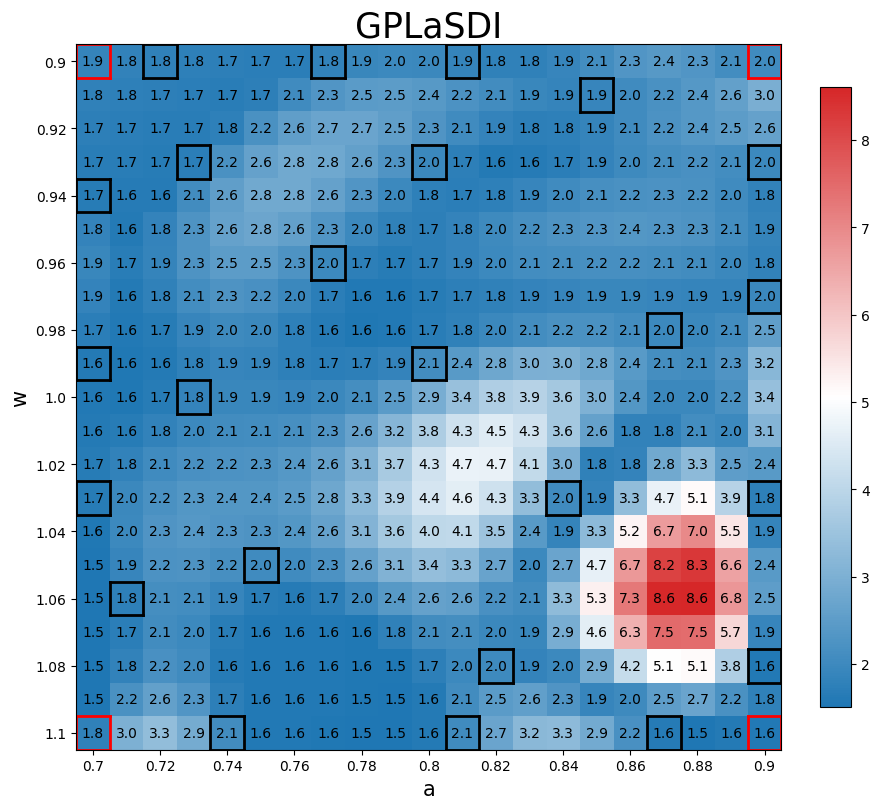

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

cmap = LinearSegmentedColormap.from_list('rg', ['C0', 'w', 'C3'], N = 256)

im = ax.imshow(max_e_relative_mean * 100, cmap = cmap)
fig.colorbar(im, ax = ax, fraction = 0.04)

ax.set_xticks(np.arange(0, n_a_grid, 2), labels=np.round(a_grid[0, ::2], 2))
ax.set_yticks(np.arange(0, n_w_grid, 2), labels=np.round(w_grid[::2, 0], 2))

for i in range(n_a_grid):
    for j in range(n_w_grid):
            ax.text(j, i, round(max_e_relative_mean[i, j] * 100, 1), ha='center', va='center', color='k')

grid_square_x = np.arange(-0.5, n_a_grid, 1)
grid_square_y = np.arange(-0.5, n_w_grid, 1)

n_train = param_train.shape[0]
for i in range(n_train):
    a_index = np.sum((a_grid[0, :] < param_train[i, 0]) * 1)
    w_index = np.sum((w_grid[:, 0] < param_train[i, 1]) * 1)

    if i < n_init:
        color = 'r'
    else:
        color = 'k'

    ax.plot([grid_square_x[a_index], grid_square_x[a_index]], [grid_square_y[w_index], grid_square_y[w_index] + 1],
            c=color, linewidth=2)
    ax.plot([grid_square_x[a_index] + 1, grid_square_x[a_index] + 1],
            [grid_square_y[w_index], grid_square_y[w_index] + 1], c=color, linewidth=2)
    ax.plot([grid_square_x[a_index], grid_square_x[a_index] + 1], [grid_square_y[w_index], grid_square_y[w_index]],
            c=color, linewidth=2)
    ax.plot([grid_square_x[a_index], grid_square_x[a_index] + 1],
            [grid_square_y[w_index] + 1, grid_square_y[w_index] + 1], c=color, linewidth=2)

ax.set_xlabel('a', fontsize=15)
ax.set_ylabel('w', fontsize=15)
ax.set_title('GPLaSDI', fontsize=25)

Text(0.5, 1.0, 'max$_{(t,x)}\\sqrt{V[\\tilde{u}_{\\xi^*}]}$   ($10^{-2}$)')

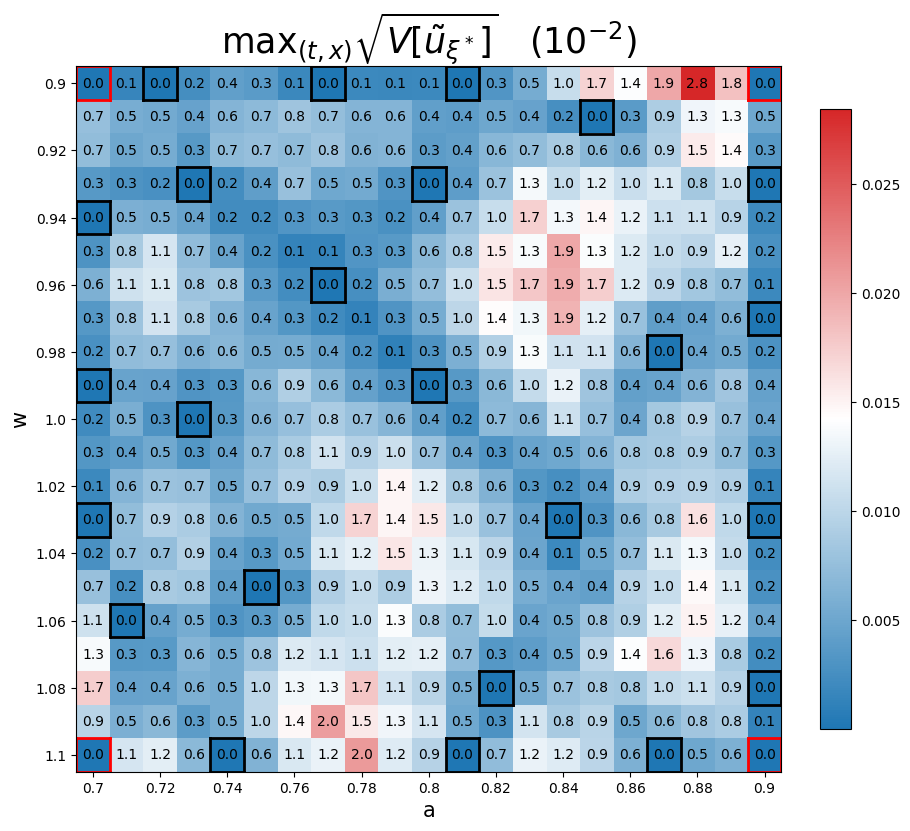

In [8]:
fig, ax = plt.subplots(figsize = (10, 10))

cmap = LinearSegmentedColormap.from_list('rg', ['C0', 'w', 'C3'], N = 256)
#cmap = plt.cm.magma

im = ax.imshow(max_std / 1, cmap = cmap)
fig.colorbar(im, ax = ax, fraction = 0.04)

ax.set_xticks(np.arange(0, n_a_grid, 2), labels=np.round(a_grid[0, ::2], 2))
ax.set_yticks(np.arange(0, n_w_grid, 2), labels=np.round(w_grid[::2, 0], 2))

digit_offset = -2

for i in range(n_a_grid):
    for j in range(n_w_grid):
        # ax.text(j, i, round(max_std[i, j], 1), ha='center', va='center', color='k')
        str_std = list('{:05f}'.format(max_std[i, j]))
        ax.text(j, i, str_std[1 - digit_offset] + '.' + str_std[2 - digit_offset], ha='center', va='center', color='k')



grid_square_x = np.arange(-0.5, n_a_grid, 1)
grid_square_y = np.arange(-0.5, n_w_grid, 1)

n_train = param_train.shape[0]
for i in range(n_train):
    a_index = np.sum((a_grid[0, :] < param_train[i, 0]) * 1)
    w_index = np.sum((w_grid[:, 0] < param_train[i, 1]) * 1)

    if i < n_init:
        color = 'r'
    else:
        color = 'k'

    ax.plot([grid_square_x[a_index], grid_square_x[a_index]], [grid_square_y[w_index], grid_square_y[w_index] + 1],
            c=color, linewidth=2)
    ax.plot([grid_square_x[a_index] + 1, grid_square_x[a_index] + 1],
            [grid_square_y[w_index], grid_square_y[w_index] + 1], c=color, linewidth=2)
    ax.plot([grid_square_x[a_index], grid_square_x[a_index] + 1], [grid_square_y[w_index], grid_square_y[w_index]],
            c=color, linewidth=2)
    ax.plot([grid_square_x[a_index], grid_square_x[a_index] + 1],
            [grid_square_y[w_index] + 1, grid_square_y[w_index] + 1], c=color, linewidth=2)

ax.set_xlabel('a', fontsize=15)
ax.set_ylabel('w', fontsize=15)
ax.set_title(r'max$_{(t,x)}\sqrt{V[\tilde{u}_{\xi^*}]}$   ($10^{%d}$)' % digit_offset, fontsize=25)

/Users/chung28/.venv_gpu/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


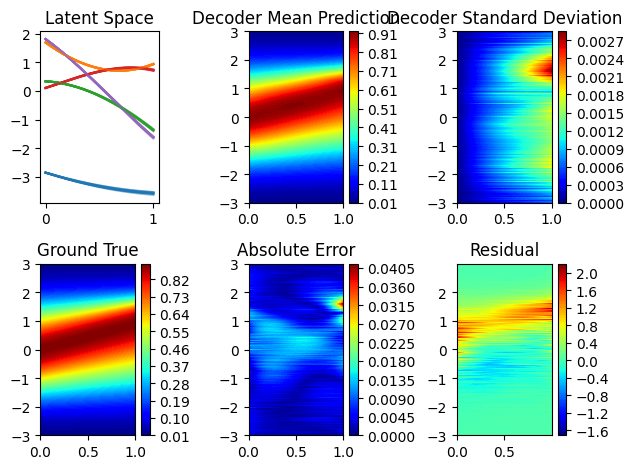

In [10]:
from lasdi.sindy import simulate_uncertain_sindy
from lasdi.postprocess import plot_prediction

a, w = 0.9, 1.07
param = np.array([[a, w]])
u0 = physics.initial_condition([a, w])
true = physics.solve([a, w])
true = true.detach().numpy().reshape([physics.grid_size[0], physics.nt]).T
scale = 1

z0 = autoencoder.encoder(torch.Tensor(u0.reshape(1, 1, -1)))
z0 = z0[0, 0, :].detach().numpy()

Z = simulate_uncertain_sindy(gp_dictionnary, param, n_samples, z0, t_grid, sindy_coef, n_coef)
Z_mean = Z.mean(0)
Z_std = Z.std(0)


pred = autoencoder.decoder(torch.Tensor(Z)).detach().numpy()
pred_std = pred.std(0)

plot_prediction(param, autoencoder, gp_dictionnary, n_samples, z0, t_grid, sindy_coef, n_coef, t_mesh, x_mesh, scale, true, Dt, Dx)